# 3. Gráficos complementares

Gráficos para complementarem a apresentação do case

### importando as bibliotecas necessárias

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from scipy.stats import f_oneway

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

%matplotlib inline

### lendo as bases tratadas

In [3]:
demographic_data = pd.read_csv('dados_tratados/demographic_data_trat.csv')
df_geocode = pd.read_csv('dados_tratados/df_geocode_trat.csv')
economic_data = pd.read_csv('dados_tratados/economic_data_trat.csv')
test_data = pd.read_csv('dados_tratados/test_data_trat.csv')
transactional_data = pd.read_csv('dados_tratados/transactional_data_trat.csv')

zipcodes_states = pd.read_excel('dados_brutos/zipcodes-states.xlsx', index_col = 0) # fontes: https://codigo-postal.co/pt-br/eua/, https://pt.wikipedia.org/wiki/Lista_de_estados_dos_Estados_Unidos_por_popula%C3%A7%C3%A3o

c:\Users\Leticia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning:

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.



### gráfico do número de exames por mês - versão em linhas

In [4]:
exames_mes = transactional_data

exames_mes['Date of service'] = pd.to_datetime(exames_mes['Date of service'])

exames_mes['mes'] = exames_mes['Date of service'].dt.strftime('%b')
exames_mes['ano'] = exames_mes['Date of service'].dt.strftime('%y')

ordem = exames_mes.sort_values('Date of service')[['mes', 'ano']].drop_duplicates()
ordem['mes_ano'] = ordem['mes'] + '/' + ordem['ano']

ordem = ordem.reset_index().reset_index()
ordem = ordem.drop(['index'], axis = 1)
ordem = ordem.rename({'level_0':'mes_ordem'}, axis = 1)
ordem['mes_ordem'] = ordem['mes_ordem'] + 1

exames_mes2 = exames_mes
exames_mes2['mes_ano'] = exames_mes2['mes'] + '/' + exames_mes2['ano']
exames_mes2 = exames_mes2.groupby('mes_ano').count()['CodItem'].reset_index().merge(ordem[['mes_ano', 'mes_ordem']], how = 'left').sort_values('mes_ordem').reset_index()
exames_mes2 = exames_mes2.drop('index', axis = 1)
exames_mes2 = exames_mes2.rename({'CodItem':'Número de exames'}, axis = 1)
exames_mes2.head()

,mes_ano,Número de exames,mes_ordem
0,Jan/19,93203,1
1,Feb/19,84560,2
2,Mar/19,102251,3
3,Apr/19,93955,4
4,May/19,91182,5


In [10]:
# número médio de exames, excluindo fev 2021
exames_mes2[exames_mes2['mes_ano'] != 'Feb/21']['Número de exames'].mean()

92254.2

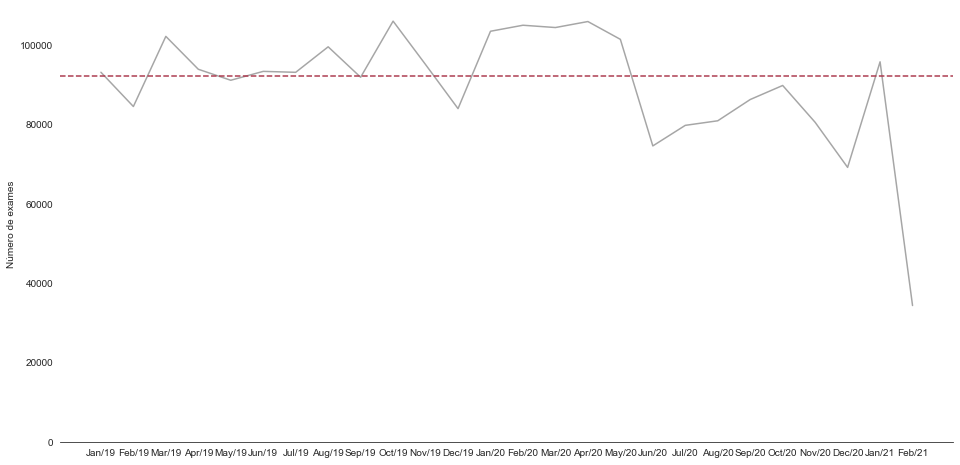

In [12]:
# gráfico

plt.figure(figsize = (16, 8))
sns.set_style('white')
fig = sns.lineplot(data = exames_mes2, x = 'mes_ano', y = 'Número de exames', color = '#a6a6a6')

# remover o título do eixo x
fig.set_xlabel('')

fig.set_ylim(0,)
# remover as bordas do gráfico
sns.despine(left = True)


# adicionar linha vertical em y = média de exames por mês
plt.axhline(y = 92254.2, linestyle='--', color='#ac3a4e')

### gráfico de mapa com bolhas com o valor médio dos exames por laboratório

In [26]:
coordenadas = df_geocode

# separando a latitude e a longitude
coordenadas['latitude'] = coordenadas['Location'].str.split(',').str[0].astype('float')
coordenadas['longitude'] = coordenadas['Location'].str.split(',').str[1].astype('float')

# separando o estado a partir da coluna de endereço
coordenadas['Sigla'] = coordenadas['Address'].str.split(', ').str[2].str.split(' ').str[0]

coordenadas = coordenadas.merge(media_preco_exames, how = 'left')
coordenadas = coordenadas.rename({'Valor Pago':'Média Valor Pago'}, axis = 1)
coordenadas['Média Valor Pago'] = coordenadas['Média Valor Pago'].fillna(0)
coordenadas

,Lab Id,Address,Location,Zipcode,latitude,longitude,Sigla,Média Valor Pago
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0,34.000319,-84.162972,GA,65.259434
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0,43.231133,-75.444536,NY,28.328888
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0,47.716279,-122.183815,WA,54.728232
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0,33.909388,-84.352910,GA,27.701021
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0,40.930993,-90.943760,IL,31.383244
...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0,39.918408,-75.035649,NJ,45.046184
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0,43.077370,-75.653690,NY,34.661707
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0,43.253010,-75.186002,NY,26.296361
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0,41.561118,-90.591518,IA,41.150734


In [39]:
scl = [[0.0, '#ac3a4e'],[1.0, '#5288db']]

data = dict(
    type = 'scattergeo',
    # colorscale = 'RdBu',
    lat = coordenadas['latitude'],
    lon = coordenadas['longitude'],
    # locations = coordenadas['state'],
    # locationmode = 'USA-states',
    # z = coordenadas['Lab Id'],
    # text = coordenadas['Address'],
    marker = dict(size = coordenadas['Média Valor Pago']/3, autocolorscale = False, colorscale = scl, color = coordenadas['Média Valor Pago'], 
                  # colorbar = dict(title = 'Valor médio')
                  ),
    # colorbar = dict(title = 'Zipcode')
)

layout = dict(
    # title = 'Média do valor pago nos exames em cada laboratório',
    geo = dict(scope = 'usa', # showlakes = True, lakecolor = 'rgb(85, 173, 240)',
               projection = dict(type ='albers usa'),showland = True,
                    landcolor="rgb(250,250,250)",subunitcolor = "rgb(100,100,100)",
                     countrycolor = "rgb(100,100,100)",countrywidth =0.5, subunitwidth=0.5)
)

choromap = go.Figure(data = [data], layout = layout)


choromap.update_layout(width = 600)
iplot(choromap, validate = False)

### percentual de clientes entre 30 e 65 anos

In [31]:
def faixa_etaria(x):
    if x < 30 :
        return 'menos de 30 anos'
    elif x <= 65:
        return 'entre 30 e 65 anos'
    elif x > 65:
        return 'mais de 65 anos'


pacientes_unicos = transactional_data.drop_duplicates(subset = 'Patient Id')
pacientes_unicos['faixa etaria'] = pacientes_unicos['Idade'].apply(faixa_etaria)

total_idade = pacientes_unicos['faixa etaria'].value_counts().to_frame()
total_idade['total'] = total_idade['faixa etaria'].sum()
total_idade['perc'] = total_idade['faixa etaria'] * 100 / total_idade['total']
total_idade

C:\Users\Leticia\AppData\Local\Temp\ipykernel_2476\2151088617.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,faixa etaria,total,perc
entre 30 e 65 anos,324530,501445,64.718962
menos de 30 anos,148007,501445,29.516098
mais de 65 anos,28908,501445,5.764939


### gráfico final id paciente

### treemap categorias dos exames

In [38]:
categorias_testes = test_data.groupby(['Category', 'Family', 'Speciality']).count()[['CodItem']].reset_index()
categorias_testes

,Category,Family,Speciality,CodItem
0,CA,COPRO,HIDDEN BLOOD,1
1,CA,COPRO,PARASITOLOGY,5
2,CA,COPRO,SPECIAL COPRO,18
3,CA,CORELAB,ALLERGY,182
4,CA,CORELAB,AUTOIMMUNITY,2
...,...,...,...,...
88,RID,ULTRASOUND,GENERAL,30
89,RID,ULTRASOUND,INVASIVE PROCEDURE,6
90,RID,ULTRASOUND,SKELETAL MUSCLE,28
91,RID,X-RAY,CONVENTIONAL,70


In [42]:
colors = ['#D9D9D9', '#BF9D7E', '#59220E', '#8C7D77', '#733C30', '#ac3a4e']

fig = px.treemap(categorias_testes,
                 path=["Category","Family","Speciality"],
                 values='CodItem',
                 color='Category',
                 color_discrete_sequence = colors,
                 width=1000, height=700,
                 title="Testes por Category, Family e Speciality",)

fig.show()

### média geral do número de exames por bateria

In [21]:
transactional_data.groupby(['Service Id']).count().reset_index()['Patient Id'].mean()

3.5462314732470883

### gráfico do número de exames

### gráfico da receita dos laboratórios

### gráfico de fidelização por estado

### gráfico de fidelização dos laboratórios